# Endangered Wildlife Image Classification
## SAIA 2133: Computer Vision - Final Project
**Universiti Teknologi Malaysia (UTM)**

NAME: MUHAMMAD LUKMAN BIN NASRUM

NO. MATRIC: A24AI0061

PROGRAMME: 2/SAIAH

## 1. Setup and Import Libraries
Import all necessary libraries and set reproducibility seeds.

In [28]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import time
import json
import kagglehub

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Metrics and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Visualization Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set Random Seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check TensorFlow and GPU
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# Configure GPU memory growth (if GPU available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1
GPU memory growth enabled


## 2. Dataset Loading and Organization
**Dataset**: [Danger of Extinction Animal Image Set](https://www.kaggle.com/datasets/brsdincer/danger-of-extinction-animal-image-set)

In [29]:
# Check if dataset already exists in cache
dataset_cache_path = Path.home() / '.cache' / 'kagglehub' / 'datasets' / 'brsdincer' / 'danger-of-extinction-animal-image-set'

if dataset_cache_path.exists() and any(dataset_cache_path.iterdir()):
    print(" Dataset already downloaded!")
    print(f" Using cached dataset from: {dataset_cache_path}")
    dataset_path = str(dataset_cache_path / 'versions' / '1')
    KAGGLE_DATASET_PATH = Path(dataset_path)
else:
    print(" Downloading dataset from Kaggle ...")
    dataset_path = kagglehub.dataset_download("brsdincer/danger-of-extinction-animal-image-set")
    print(f"\n Dataset downloaded successfully!")
    print(f" Path to dataset files: {dataset_path}")
    KAGGLE_DATASET_PATH = Path(dataset_path)

Using Colab cache for faster access to the 'danger-of-extinction-animal-image-set' dataset.

 Dataset downloaded successfully!
 Path to dataset files: /kaggle/input/danger-of-extinction-animal-image-set


In [30]:
# Define paths
# Use kagglehub downloaded path
if 'KAGGLE_DATASET_PATH' in locals():
    BASE_DIR = KAGGLE_DATASET_PATH
    # Check if there's a subdirectory with the dataset name
    danger_dir = BASE_DIR / 'Danger Of Extinction'
    if danger_dir.exists():
        BASE_DIR = danger_dir
        print(f" Using subdirectory: {danger_dir.name}")
else:
    # Fallback to manual download location
    BASE_DIR = Path('../data/danger-of-extinction')

MODELS_DIR = Path('../models')
RESULTS_DIR = Path('../results')

# Create directories if they don't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Image parameters
IMG_SIZE = (224, 224)  # Standard size for MobileNetV2 and most pre-trained models
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

print(f" Dataset directory: {BASE_DIR}")
print(f" Models directory: {MODELS_DIR}")
print(f" Results directory: {RESULTS_DIR}")

# Check if dataset exists
if not BASE_DIR.exists():
    print(f"\n Dataset not found at {BASE_DIR}")
    print("Please run the dataset download cell above.")
else:
    print(f"\n Dataset found at {BASE_DIR}")
    
# Load dataset information into a DataFrame
def load_dataset_info(base_path):
    data = []
    # Iterate through class folders
    for class_folder in sorted(base_path.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name
            
            # Get all images in class folder
            for img_path in class_folder.glob('*'):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    data.append({
                        'filepath': str(img_path),
                        'filename': img_path.name,
                        'class': class_name,
                        'class_folder': class_folder.name
                    })
    
    df = pd.DataFrame(data)
    return df

# Load dataset
if BASE_DIR.exists():
    dataset_df = load_dataset_info(BASE_DIR)
    
    if len(dataset_df) > 0:
        print(f"\n Dataset Overview:")
        print(f"Total Images: {len(dataset_df)}")
        print(f"Number of Classes: {dataset_df['class'].nunique()}")
        print(f"\n Classes found: {sorted(dataset_df['class'].unique())}")
        print(f"\n Class distribution:")
        print(dataset_df['class'].value_counts())
        
    else:
        print("\n No images found in dataset directory")
        print("Please ensure images are organized in class folders")
else:
    print("\n Please download the dataset by running the cell above")
    dataset_df = pd.DataFrame()  # Empty dataframe

 Using subdirectory: Danger Of Extinction
 Dataset directory: /kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction
 Models directory: ../models
 Results directory: ../results

 Dataset found at /kaggle/input/danger-of-extinction-animal-image-set/Danger Of Extinction

 Dataset Overview:
Total Images: 6483
Number of Classes: 11

 Classes found: ['African_Elephant', 'Amur_Leopard', 'Arctic_Fox', 'Chimpanzee', 'Jaguars', 'Lion', 'Orangutan', 'Panda', 'Panthers', 'Rhino', 'cheetahs']

 Class distribution:
class
Panda               845
Lion                806
Rhino               773
cheetahs            590
Jaguars             577
Panthers            565
Amur_Leopard        530
Orangutan           496
African_Elephant    470
Chimpanzee          462
Arctic_Fox          369
Name: count, dtype: int64


In [31]:
# Filter dataset to Malaysia-specific endangered species
if len(dataset_df) > 0:
    print("\n" + "="*80)
    print("Filtering to Malaysia-Specific Endangered Species (4 Classes)")
    print("="*80)
    
    # Define the 4 Malaysia-relevant classes
    malaysia_classes = {
        'Orangutan': 'Orangutan',  # Critically endangered in Sabah & Sarawak
        'Panthers': 'Panthers',     # Malayan Black Panther (largest population)
        'African_Elephant': 'Elephant',  # Representing Asian/Bornean Pygmy Elephant
        'Rhino': 'Rhino'           # Sumatran Rhino (extinct in Malaysia 2019)
    }
    
    print(f"\nChecking which target classes exist in dataset:")
    for original_name, display_name in malaysia_classes.items():
        count = len(dataset_df[dataset_df['class'] == original_name])
        status = "Found" if count > 0 else "Missing"
        print(f"   [{status}] {original_name}: {count} images -> will be renamed to '{display_name}'")
    
    # Filter dataset to only include these classes
    dataset_df = dataset_df[dataset_df['class'].isin(malaysia_classes.keys())].copy()
    
    print(f"\nAfter filtering (before rename): {len(dataset_df)} total images")
    
    # Rename classes for clarity
    dataset_df['class'] = dataset_df['class'].replace(malaysia_classes)

    print(f"\nFinal Class Distribution (4 Malaysia-Specific Endangered Species):")
    class_dist = dataset_df['class'].value_counts().sort_index()
    for class_name, count in class_dist.items():
        percentage = (count / len(dataset_df)) * 100
        print(f"   • {class_name:12s}: {count:4d} images ({percentage:5.1f}%)")
    
    print(f"\nTotal: {len(dataset_df)} images across {len(class_dist)} classes")
    print("="*80)
else:
    print("No dataset to filter")



Filtering to Malaysia-Specific Endangered Species (4 Classes)

Checking which target classes exist in dataset:
   [Found] Orangutan: 496 images -> will be renamed to 'Orangutan'
   [Found] Panthers: 565 images -> will be renamed to 'Panthers'
   [Found] African_Elephant: 470 images -> will be renamed to 'Elephant'
   [Found] Rhino: 773 images -> will be renamed to 'Rhino'

After filtering (before rename): 2304 total images

Final Class Distribution (4 Malaysia-Specific Endangered Species):
   • Elephant    :  470 images ( 20.4%)
   • Orangutan   :  496 images ( 21.5%)
   • Panthers    :  565 images ( 24.5%)
   • Rhino       :  773 images ( 33.6%)

Total: 2304 images across 4 classes


## 3. Exploratory Data Analysis (EDA)

This section analyzes:
- Class distribution (balanced vs imbalanced)
- Sample images from each class
- Image dimensions and statistics
- Dataset quality assessment

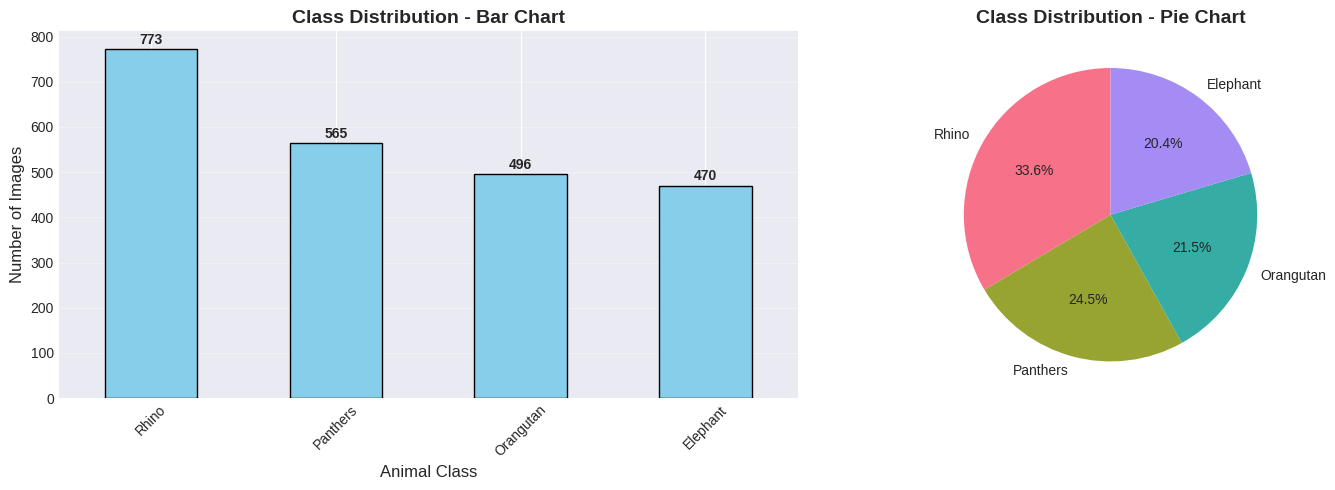


Class Distribution Statistics:
class
Rhino        773
Panthers     565
Orangutan    496
Elephant     470
Name: count, dtype: int64

Mean images per class: 576.00
Std deviation: 137.31
Min images: 470
Max images: 773
Imbalance ratio: 1.64x
RESULT: Classes are relatively balanced


In [32]:
# 3.1 Class Distribution Analysis
if len(dataset_df) > 0:
    class_counts = dataset_df['class'].value_counts()
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart
    class_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Animal Class', fontsize=12)
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, v in enumerate(class_counts.values):
        axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette('husl', len(class_counts)))
    axes[1].set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical summary
    print("\nClass Distribution Statistics:")
    print("="*60)
    print(class_counts)
    print("\n" + "="*60)
    print(f"Mean images per class: {class_counts.mean():.2f}")
    print(f"Std deviation: {class_counts.std():.2f}")
    print(f"Min images: {class_counts.min()}")
    print(f"Max images: {class_counts.max()}")
    
    # Check for class imbalance
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}x")
    
    if imbalance_ratio > 2:
        print("WARNING: Significant class imbalance detected - consider using class weights")
    else:
        print("RESULT: Classes are relatively balanced")
else:
    print("WARNING: Dataset not loaded. Please download dataset first.")

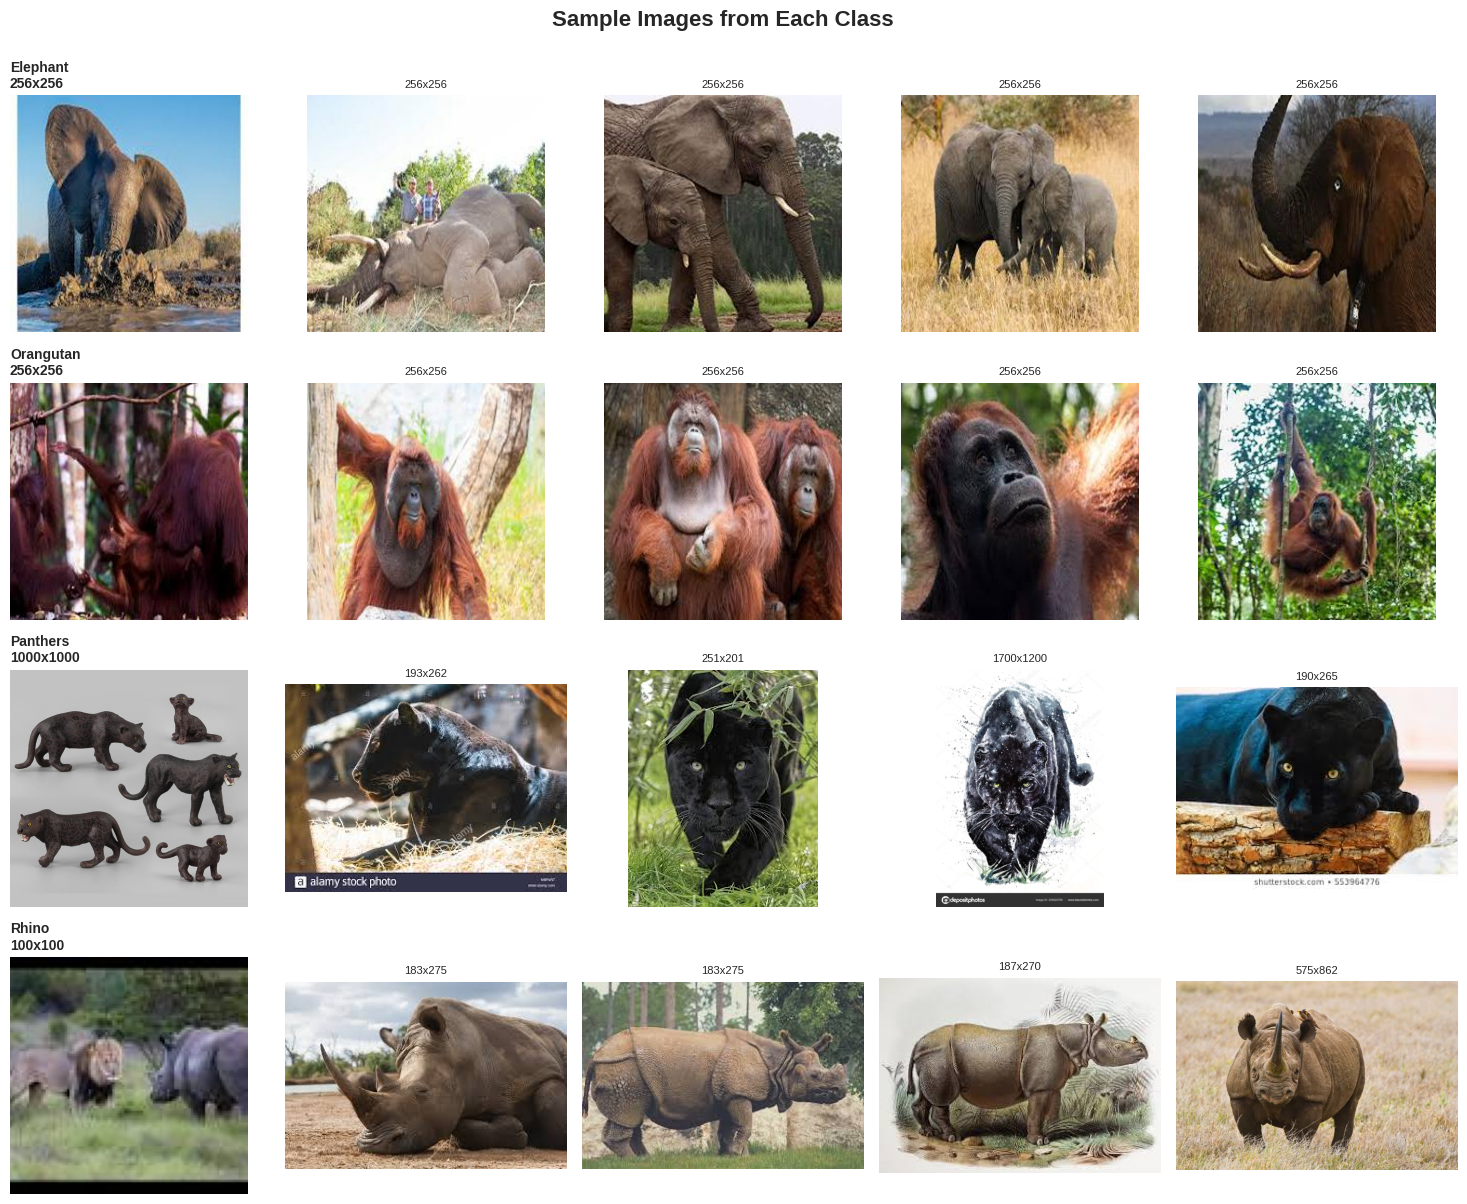

In [33]:
# 3.2 Sample Images Visualization
if len(dataset_df) > 0:
    num_classes = min(len(dataset_df['class'].unique()), 6)  # Show up to 6 classes
    samples_per_class = 5
    
    fig, axes = plt.subplots(num_classes, samples_per_class, 
                             figsize=(15, 3*num_classes))
    
    if num_classes == 1:
        axes = axes.reshape(1, -1)
    
    for idx, class_name in enumerate(sorted(dataset_df['class'].unique())[:num_classes]):
        # Get sample images from this class
        class_images = dataset_df[dataset_df['class'] == class_name].sample(
            min(samples_per_class, len(dataset_df[dataset_df['class'] == class_name])),
            random_state=SEED
        )
        
        for col, (_, row) in enumerate(class_images.iterrows()):
            if col >= samples_per_class:
                break
                
            # Load and display image
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx, col].imshow(img)
            axes[idx, col].axis('off')
            
            # Add title to first column
            if col == 0:
                axes[idx, col].set_title(f"{class_name}\n{img.shape[0]}x{img.shape[1]}", 
                                        fontsize=10, fontweight='bold', loc='left')
            else:
                axes[idx, col].set_title(f"{img.shape[0]}x{img.shape[1]}", fontsize=8)
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("WARNING: Dataset not loaded. Please download dataset first.")


📐 Image Dimensions Analysis (n=500 images):

Width - Mean: 335, Std: 418
       Range: 24-5246

Height - Mean: 270, Std: 287
        Range: 24-3497

Channels: [3]


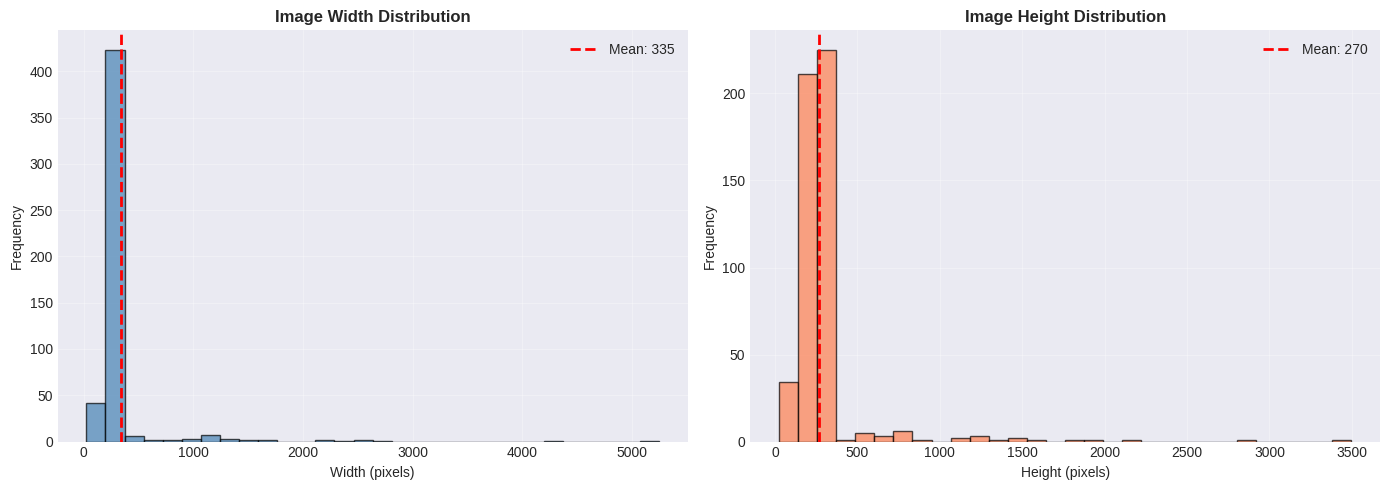


NOTE: Images will be resized to (224, 224) for model training


In [34]:
# 3.3 Image Dimensions Analysis
if len(dataset_df) > 0:
    # Sample images to analyze dimensions (analyze subset for speed)
    sample_size = min(500, len(dataset_df))
    sample_df = dataset_df.sample(sample_size, random_state=SEED)
    
    dimensions = []
    for filepath in sample_df['filepath']:
        img = cv2.imread(filepath)
        if img is not None:
            h, w, c = img.shape
            dimensions.append({'width': w, 'height': h, 'channels': c})
    
    dims_df = pd.DataFrame(dimensions)
    
    print(f"\n📐 Image Dimensions Analysis (n={len(dims_df)} images):")
    print("="*60)
    print(f"\nWidth - Mean: {dims_df['width'].mean():.0f}, Std: {dims_df['width'].std():.0f}")
    print(f"       Range: {dims_df['width'].min()}-{dims_df['width'].max()}")
    print(f"\nHeight - Mean: {dims_df['height'].mean():.0f}, Std: {dims_df['height'].std():.0f}")
    print(f"        Range: {dims_df['height'].min()}-{dims_df['height'].max()}")
    print(f"\nChannels: {dims_df['channels'].unique()}")
    
    # Visualize dimensions distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(dims_df['width'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(dims_df['width'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {dims_df['width'].mean():.0f}")
    axes[0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(dims_df['height'], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(dims_df['height'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {dims_df['height'].mean():.0f}")
    axes[1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'image_dimensions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nNOTE: Images will be resized to {IMG_SIZE} for model training")
else:
    print("WARNING: Dataset not loaded. Please download dataset first.")

## 4. Data Preprocessing and Augmentation Pipeline
**Rubric Requirement (7 marks)**: Standardization, normalization, and augmentation

This section implements:
- **Standardization**: Resize all images to 224×224
- **Normalization**: Scale pixel values to [0, 1]
- **Augmentation**: Rotation (±20°), horizontal/vertical flip, brightness adjustment (0.8-1.2)

In [35]:
# 4.1 Define Image Data Generators with Augmentation

# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize to [0,1]
    rotation_range=20,                 # Random rotation ±20 degrees
    width_shift_range=0.2,             # Horizontal shift
    height_shift_range=0.2,            # Vertical shift
    horizontal_flip=True,              # Random horizontal flip
    vertical_flip=True,                # Random vertical flip
    brightness_range=[0.8, 1.2],       # Brightness adjustment
    zoom_range=0.2,                    # Random zoom
    fill_mode='nearest'                # Fill strategy for empty pixels
)

# Validation Data Generator 
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Test Data Generator 
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Data Generators Created:")
print("   - Training: With augmentation (rotation, flip, brightness, zoom)")
print("   - Validation: Rescaling only")
print("   - Test: Rescaling only")
print(f"\nConfiguration:")
print(f"   - Target Image Size: {IMG_SIZE}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Normalization: [0, 1]")

Data Generators Created:
   - Training: With augmentation (rotation, flip, brightness, zoom)
   - Validation: Rescaling only
   - Test: Rescaling only

Configuration:
   - Target Image Size: (224, 224)
   - Batch Size: 32
   - Normalization: [0, 1]


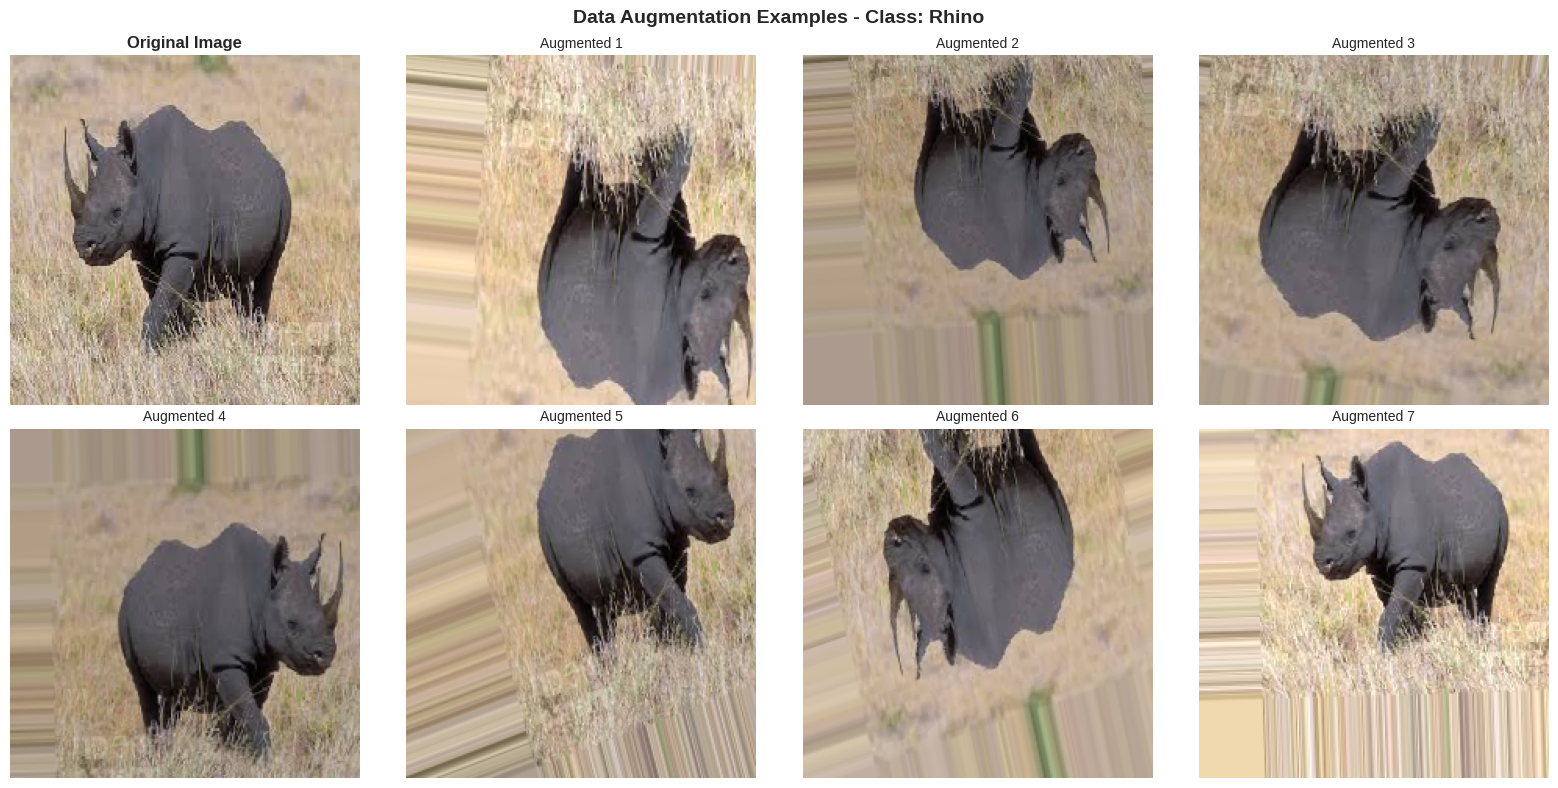

Augmentation preview generated
Notice: rotation, flipping, brightness, and zoom variations


In [36]:
# 4.2 Visualize Augmentation Effects
if len(dataset_df) > 0:
    # Get a random sample image
    sample_row = dataset_df.sample(1, random_state=SEED).iloc[0]
    sample_img_path = sample_row['filepath']
    sample_class = sample_row['class']
    
    # Load image
    img = load_img(sample_img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension
    
    # Generate augmented versions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Generate 7 augmented versions
    i = 1
    for batch in train_datagen.flow(img_array, batch_size=1):
        axes[i].imshow(batch[0])
        axes[i].set_title(f'Augmented {i}', fontsize=10)
        axes[i].axis('off')
        i += 1
        if i >= 8:
            break
    
    plt.suptitle(f'Data Augmentation Examples - Class: {sample_class}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'augmentation_examples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Augmentation preview generated")
    print("Notice: rotation, flipping, brightness, and zoom variations")
else:
    print("WARNING: Dataset not loaded. Please download dataset first.")

## 5. Train-Validation-Test Split
**Rubric Requirement (13 marks)**: Proper data split - 70% Train, 15% Validation, 15% Test

This section:
- Splits dataset with stratification (maintains class distribution)
- Creates data generators for each split
- Verifies split proportions

In [37]:
# 5.1 Create Train/Val/Test splits - PROPER NON-OVERLAPPING SPLIT FOR 4 FILTERED CLASSES
if len(dataset_df) > 0 and BASE_DIR.exists():
    from sklearn.model_selection import train_test_split
    
    # Define the 4 Malaysia-relevant classes explicitly
    # NOTE: dataset_df already has 'African_Elephant' renamed to 'Elephant'
    target_classes = ['Orangutan', 'Panthers', 'Elephant', 'Rhino']
    
    print("="*80)
    print(f"🎯 Creating PROPER 70/15/15 split for {len(target_classes)} FILTERED CLASSES")
    print(f"   Target Classes: {', '.join(target_classes)}")
    print("="*80)
    
    # Filter dataset to only include the 4 target classes
    filtered_df = dataset_df[dataset_df['class'].isin(target_classes)].copy()
    
    print(f"\n📊 Original dataset: {len(dataset_df)} images")
    print(f"📊 Filtered dataset: {len(filtered_df)} images ({len(filtered_df)/len(dataset_df)*100:.1f}%)")
    print(f"\n📂 Class distribution in filtered dataset:")
    for class_name in target_classes:
        count = len(filtered_df[filtered_df['class'] == class_name])
        print(f"   {class_name}: {count} images")
    
    # Perform stratified train/val/test split (70/15/15)
    # First split: 70% train, 30% temp (for val+test)
    train_df, temp_df = train_test_split(
        filtered_df, 
        test_size=0.3, 
        stratify=filtered_df['class'],
        random_state=SEED
    )
    
    # Second split: split the 30% into 15% val and 15% test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,  # 50% of 30% = 15% of total
        stratify=temp_df['class'],
        random_state=SEED
    )
    
    print(f"\nSplit completed:")
    print(f"   Training:   {len(train_df)} images ({len(train_df)/len(filtered_df)*100:.1f}%)")
    print(f"   Validation: {len(val_df)} images ({len(val_df)/len(filtered_df)*100:.1f}%)")
    print(f"   Test:       {len(test_df)} images ({len(test_df)/len(filtered_df)*100:.1f}%)")
    print(f"   Total:      {len(train_df) + len(val_df) + len(test_df)} images")
    
    # Verify no overlap
    assert len(set(train_df.index) & set(val_df.index)) == 0, "Train/Val overlap detected!"
    assert len(set(train_df.index) & set(test_df.index)) == 0, "Train/Test overlap detected!"
    assert len(set(val_df.index) & set(test_df.index)) == 0, "Val/Test overlap detected!"
    print(f"   VERIFIED: No data leakage - all splits are non-overlapping")
    
    print("="*80)
    
    # Create data generators using flow_from_dataframe
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filepath',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )
    
    # Get class information
    class_indices = train_generator.class_indices
    num_classes = len(class_indices)
    class_names = list(class_indices.keys())
    
    print(f"\n✅ Data Generators Created Successfully!")
    print("="*60)
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"\nTotal samples: {train_generator.samples + val_generator.samples + test_generator.samples}")
    print(f"Number of classes: {num_classes} ({'✅ FILTERED' if num_classes == 4 else '⚠️ NOT FILTERED'})")
    print(f"Class names: {class_names}")
    print(f"Class indices: {class_indices}")
    
    print(f"\n📊 Per-class distribution in splits:")
    for class_name in class_names:
        train_count = len(train_df[train_df['class'] == class_name])
        val_count = len(val_df[val_df['class'] == class_name])
        test_count = len(test_df[test_df['class'] == class_name])
        total_count = train_count + val_count + test_count
        print(f"   {class_name}:")
        print(f"      Train: {train_count:4d} ({train_count/total_count*100:5.1f}%)")
        print(f"      Val:   {val_count:4d} ({val_count/total_count*100:5.1f}%)")
        print(f"      Test:  {test_count:4d} ({test_count/total_count*100:5.1f}%)")
    
    print(f"\nBatch size: {BATCH_SIZE}")
    print(f"Steps per epoch (train): {train_generator.samples // BATCH_SIZE}")
    print(f"Validation steps: {val_generator.samples // BATCH_SIZE}")
    
    # Verify we have exactly 4 classes
    if num_classes != 4:
        print(f"\nWARNING: Expected 4 classes but got {num_classes}")
    else:
        print(f"\nCONFIRMED: Using exactly 4 filtered classes with proper 70/15/15 split")
        print(f"   No data leakage - each image appears in only one split")
    
else:
    print("WARNING: Dataset not loaded. Please download dataset first.")
    train_generator = None
    val_generator = None
    test_generator = None
    num_classes = 0
    class_names = []

🎯 Creating PROPER 70/15/15 split for 4 FILTERED CLASSES
   Target Classes: Orangutan, Panthers, Elephant, Rhino

📊 Original dataset: 2304 images
📊 Filtered dataset: 2304 images (100.0%)

📂 Class distribution in filtered dataset:
   Orangutan: 496 images
   Panthers: 565 images
   Elephant: 470 images
   Rhino: 773 images

Split completed:
   Training:   1612 images (70.0%)
   Validation: 346 images (15.0%)
   Test:       346 images (15.0%)
   Total:      2304 images
   VERIFIED: No data leakage - all splits are non-overlapping
Found 1612 validated image filenames belonging to 4 classes.
Found 346 validated image filenames belonging to 4 classes.
Found 346 validated image filenames belonging to 4 classes.

✅ Data Generators Created Successfully!
Training samples: 1612
Validation samples: 346
Test samples: 346

Total samples: 2304
Number of classes: 4 (✅ FILTERED)
Class names: ['Elephant', 'Orangutan', 'Panthers', 'Rhino']
Class indices: {'Elephant': 0, 'Orangutan': 1, 'Panthers': 2, 'Rh

## 6. Model A: Custom Lightweight CNN Architecture
**Rubric Requirement (10 marks)**: Design a custom CNN model

Architecture Features:
- 4 Convolutional blocks (Conv2D → BatchNormalization → ReLU → MaxPooling)
- Progressive filter increase: 32 → 64 → 128 → 256
- Dropout for regularization (0.3-0.5)
- Dense layers for classification
- Lightweight design (~1-2M parameters)

In [38]:
# 6.1 Define Custom CNN Architecture

def create_custom_cnn(input_shape, num_classes):
    """
    Compact CNN architecture for wildlife classification
    - 3 Convolutional blocks with increasing filters (32→64→128)
    - Global Average Pooling to reduce parameters
    - Single dropout layer for regularization
    """
    model = tf.keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name="CustomCNN")
    return model

# Create and compile the model
if num_classes > 0:
    custom_cnn = create_custom_cnn(IMG_SHAPE, num_classes)
    
    custom_cnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    print("="*80)
    print("CUSTOM CNN ARCHITECTURE")
    print("="*80)
    custom_cnn.summary()
    
    total_params = custom_cnn.count_params()
    print(f"\nModel Statistics:")
    print(f"   Total Parameters: {total_params:,}")
    print(f"   Trainable Parameters: {sum([tf.size(w).numpy() for w in custom_cnn.trainable_weights]):,}")
    print(f"   Estimated Size: {total_params * 4 / (1024**2):.2f} MB (float32)")
    
else:
    print("WARNING: Cannot create model without dataset. Please load dataset first.")
    custom_cnn = None

CUSTOM CNN ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,764 (366.27 KB)

 Trainable params: 93,764 (366.27 KB)

 Non-trainable params: 0 (0.00 B)


Model Statistics:
   Total Parameters: 93,764
   Trainable Parameters: 93,764
   Estimated Size: 0.36 MB (float32)


## 7. Model B: Transfer Learning with MobileNetV2
**Rubric Requirement (10 marks)**: Implement transfer learning model

Using MobileNetV2 pre-trained on ImageNet:
- Freeze convolutional base layers (feature extraction)
- Add custom classification head
- Fine-tuning option available
- Lightweight architecture ~3.5M parameters (base model)
- Optimized for mobile and embedded devices

In [39]:
# 7.1 Create Transfer Learning Model with MobileNetV2
def create_transfer_learning_model(input_shape, num_classes, base_trainable=False):
    """
    Create a transfer learning model using MobileNetV2
    
    Args:
        input_shape: Input image shape (224, 224, 3)
        num_classes: Number of output classes
        base_trainable: Whether to train the base model layers
    """
    # Load pre-trained MobileNetV2 (without top classification layers)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = base_trainable
    
    # Build the model
    model = models.Sequential(name='MobileNetV2_Transfer')
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    
    # Custom classification head
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model, base_model

# Create the transfer learning model
if num_classes > 0:
    transfer_model, base_model = create_transfer_learning_model(IMG_SHAPE, num_classes, base_trainable=False)
    
    # Compile the model
    transfer_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    # Display model summary
    print("="*80)
    print("TRANSFER LEARNING MODEL (MobileNetV2)")
    print("="*80)
    transfer_model.summary()
    
    # Model statistics
    total_params = transfer_model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in transfer_model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    
    print(f"\nModel Statistics:")
    print(f"   Total Parameters: {total_params:,}")
    print(f"   Trainable Parameters: {trainable_params:,}")
    print(f"   Non-Trainable Parameters (Frozen): {non_trainable_params:,}")
    print(f"   Estimated Size: {total_params * 4 / (1024**2):.2f} MB (float32)")
    print(f"\n   Base Model (MobileNetV2): {'Frozen' if not base_model.trainable else 'Trainable'}")
    
else:
    print("WARNING: Cannot create model without dataset. Please load dataset first.")
    transfer_model = None

TRANSFER LEARNING MODEL (MobileNetV2)


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,053,380 (11.65 MB)

 Trainable params: 791,812 (3.02 MB)

 Non-trainable params: 2,261,568 (8.63 MB)


Model Statistics:
   Total Parameters: 3,053,380
   Trainable Parameters: 791,812
   Non-Trainable Parameters (Frozen): 2,261,568
   Estimated Size: 11.65 MB (float32)

   Base Model (MobileNetV2): Frozen


## 8. Training Configuration and Callbacks
Setup callbacks for training optimization and model checkpointing.

In [40]:
# 8.1 Define Callbacks for Training
EPOCHS = 30  # Can be adjusted based on available time
PATIENCE = 7  # Early stopping patience

# Create callbacks for Custom CNN
custom_cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'custom_cnn_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    CSVLogger(str(RESULTS_DIR / 'custom_cnn_training_log.csv'))
]

# Create callbacks for Transfer Learning Model
transfer_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(MODELS_DIR / 'mobilenetv2_transfer_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    CSVLogger(str(RESULTS_DIR / 'mobilenetv2_training_log.csv'))
]

print("Training Configuration:")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Early Stopping Patience: {PATIENCE}")
print(f"   - Callbacks: EarlyStopping + ModelCheckpoint + CSV Logger")
print(f"   - Best models will be saved during training to: {MODELS_DIR}")

Training Configuration:
   - Epochs: 30
   - Early Stopping Patience: 7
   - Callbacks: EarlyStopping + ModelCheckpoint + CSV Logger
   - Best models will be saved during training to: ../models


In [41]:
# # Calculate class weights to handle imbalance
# if len(dataset_df) > 0:
#     from sklearn.utils.class_weight import compute_class_weight
    
#     print("="*80)
#     print("⚖️  Computing Class Weights for Imbalanced Dataset")
#     print("="*80)
    
#     # Get class distribution
#     class_counts = dataset_df['class'].value_counts().sort_index()
#     print(f"\n📊 Current Class Distribution:")
#     for class_name, count in class_counts.items():
#         print(f"   {class_name}: {count} images")
    
#     # Calculate imbalance ratio
#     max_count = class_counts.max()
#     min_count = class_counts.min()
#     imbalance_ratio = max_count / min_count
#     print(f"\n📈 Imbalance Ratio: {imbalance_ratio:.2f}x")
    
#     if imbalance_ratio > 1.5:
#         print("   ⚠️  Significant imbalance detected - applying class weights")
        
#         # Compute class weights using sklearn
#         class_labels = sorted(dataset_df['class'].unique())
#         class_weights_array = compute_class_weight(
#             class_weight='balanced',
#             classes=np.array(class_labels),
#             y=dataset_df['class']
#         )
        
#         # Create class weight dictionary
#         class_weight_dict = dict(enumerate(class_weights_array))
        
#         print(f"\n⚖️  Computed Class Weights:")
#         for idx, class_name in enumerate(class_labels):
#             weight = class_weight_dict[idx]
#             print(f"   {idx}. {class_name}: {weight:.4f} (multiply loss by this factor)")
        
#         print(f"\n💡 Impact:")
#         print(f"   - Classes with fewer samples get higher weights")
#         print(f"   - This penalizes the model more for misclassifying minority classes")
#         print(f"   - Helps prevent model bias toward majority class (Rhino)")
        
#     else:
#         print("   ✅ Classes are relatively balanced - no weights needed")
#         class_weight_dict = None
    
#     print("="*80)
# else:
#     print("⚠️ Dataset not loaded")
#     class_weight_dict = None

## 9. Model Training - Custom CNN
Train the custom lightweight CNN model.

In [42]:
# 9.1 Train Custom CNN
if custom_cnn is not None and train_generator is not None:
    print("="*80)
    print("🚀 Training Custom CNN Model")
    print("="*80)
    
    start_time = time.time()
    
    history_custom = custom_cnn.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=custom_cnn_callbacks,
        # class_weight=class_weight_dict,
        verbose=1
    )
    
    training_time_custom = time.time() - start_time
    
    print(f"\nCustom CNN Training Complete!")
    print(f"Training Time: {training_time_custom/60:.2f} minutes ({training_time_custom:.2f} seconds)")
    
    with open(RESULTS_DIR / 'custom_cnn_training_time.txt', 'w') as f:
        f.write(f"Training Time: {training_time_custom:.2f} seconds\n")
        f.write(f"Training Time: {training_time_custom/60:.2f} minutes\n")
    
else:
    print("WARNING: Cannot train model. Please ensure dataset is loaded and model is created.")
    history_custom = None
    training_time_custom = 0

🚀 Training Custom CNN Model


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.3199 - auc: 0.5765 - loss: 1.3626 - precision: 0.6111 - recall: 0.0050
Epoch 1: val_accuracy improved from -inf to 0.43931, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 663ms/step - accuracy: 0.3207 - auc: 0.5774 - loss: 1.3620 - precision: 0.6122 - recall: 0.0053 - val_accuracy: 0.4393 - val_auc: 0.7378 - val_loss: 1.2057 - val_precision: 0.7447 - val_recall: 0.1012
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.4369 - auc: 0.7086 - loss: 1.2351 - precision: 0.5782 - recall: 0.1396
Epoch 2: val_accuracy improved from 0.43931 to 0.49422, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 580ms/step - accuracy: 0.4367 - auc: 0.7085 - loss: 1.2352 - precision: 0.5785 - recall: 0.1390 - val_accuracy: 0.4942 - val_auc: 0.7685 - val_loss: 1.1505 - val_precision: 0.8200 - val_recall: 0.1185
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4758 - auc: 0.7278 - loss: 1.2041 - precision: 0.7237 - recall: 0.1158
Epoch 3: val_accuracy did not improve from 0.49422
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 600ms/step - accuracy: 0.4758 - auc: 0.7280 - loss: 1.2040 - precision: 0.7227 - recall: 0.1159 - val_accuracy: 0.4798 - val_auc: 0.7380 - val_loss: 1.1859 - val_precision: 0.6260 - val_recall: 0.2225
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.4970 - auc: 0.7442 - loss: 1.1719 - precision: 0.6365 - recall: 0.1756
Epoch 4: val_accuracy improved from 0.49422 to 0.53468, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 580ms/step - accuracy: 0.4971 - auc: 0.7443 - loss: 1.1718 - precision: 0.6367 - recall: 0.1756 - val_accuracy: 0.5347 - val_auc: 0.7830 - val_loss: 1.1042 - val_precision: 0.6566 - val_recall: 0.1879
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5046 - auc: 0.7709 - loss: 1.1227 - precision: 0.6700 - recall: 0.2185
Epoch 5: val_accuracy did not improve from 0.53468
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step - accuracy: 0.5048 - auc: 0.7710 - loss: 1.1225 - precision: 0.6698 - recall: 0.2186 - val_accuracy: 0.5289 - val_auc: 0.7870 - val_loss: 1.1031 - val_precision: 0.6423 - val_recall: 0.2283
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.5533 - auc: 0.7960 - loss: 1.0754 - precision: 0.6936 - recall: 0.2721
Epoch 6: val_accuracy improved from 0.53468 to 0.55780, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 581ms/step - accuracy: 0.5532 - auc: 0.7960 - loss: 1.0754 - precision: 0.6933 - recall: 0.2722 - val_accuracy: 0.5578 - val_auc: 0.8252 - val_loss: 1.0213 - val_precision: 0.7353 - val_recall: 0.2168
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5595 - auc: 0.8174 - loss: 1.0272 - precision: 0.6905 - recall: 0.3125
Epoch 7: val_accuracy did not improve from 0.55780
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 601ms/step - accuracy: 0.5596 - auc: 0.8174 - loss: 1.0272 - precision: 0.6906 - recall: 0.3125 - val_accuracy: 0.5549 - val_auc: 0.8286 - val_loss: 0.9945 - val_precision: 0.7315 - val_recall: 0.3150
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5722 - auc: 0.8228 - loss: 1.0190 - precision: 0.7007 - recall: 0.3407
Epoch 8: val_accuracy improved from 0.55780 to 0.60694, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - accuracy: 0.5723 - auc: 0.8231 - loss: 1.0183 - precision: 0.7009 - recall: 0.3410 - val_accuracy: 0.6069 - val_auc: 0.8299 - val_loss: 0.9918 - val_precision: 0.6991 - val_recall: 0.4364
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6052 - auc: 0.8473 - loss: 0.9425 - precision: 0.6944 - recall: 0.4074
Epoch 9: val_accuracy improved from 0.60694 to 0.66185, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 592ms/step - accuracy: 0.6052 - auc: 0.8471 - loss: 0.9429 - precision: 0.6943 - recall: 0.4068 - val_accuracy: 0.6618 - val_auc: 0.8756 - val_loss: 0.8735 - val_precision: 0.7462 - val_recall: 0.4249
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.6064 - auc: 0.8446 - loss: 0.9655 - precision: 0.7131 - recall: 0.4033
Epoch 10: val_accuracy did not improve from 0.66185
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 577ms/step - accuracy: 0.6065 - auc: 0.8447 - loss: 0.9651 - precision: 0.7129 - recall: 0.4035 - val_accuracy: 0.6532 - val_auc: 0.8779 - val_loss: 0.8541 - val_precision: 0.7692 - val_recall: 0.4913
Epoch 11/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6362 - auc: 0.8587 - loss: 0.9198 - precision: 0.7429 - recall: 0.4431
Epoch 11: val_accuracy improved from 0.66185 to 0.70809, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.6359 - auc: 0.8586 - loss: 0.9200 - precision: 0.7425 - recall: 0.4429 - val_accuracy: 0.7081 - val_auc: 0.8911 - val_loss: 0.8381 - val_precision: 0.7989 - val_recall: 0.4133
Epoch 12/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6483 - auc: 0.8673 - loss: 0.8996 - precision: 0.7438 - recall: 0.4398
Epoch 12: val_accuracy did not improve from 0.70809
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - accuracy: 0.6481 - auc: 0.8672 - loss: 0.8996 - precision: 0.7436 - recall: 0.4402 - val_accuracy: 0.6532 - val_auc: 0.8815 - val_loss: 0.8344 - val_precision: 0.7489 - val_recall: 0.5000
Epoch 13/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.6109 - auc: 0.8574 - loss: 0.9086 - precision: 0.7002 - recall: 0.4496
Epoch 13: val_accuracy did not improve from 0.70809
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - accuracy: 0.6109 - auc: 0.8573 - loss: 0.9091 - precision: 0.7003 - recall: 0.4494 - val_accuracy: 0.6734 - val_

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 580ms/step - accuracy: 0.6513 - auc: 0.8764 - loss: 0.8571 - precision: 0.7426 - recall: 0.5067 - val_accuracy: 0.7197 - val_auc: 0.9034 - val_loss: 0.7780 - val_precision: 0.7941 - val_recall: 0.5462
Epoch 18/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6413 - auc: 0.8782 - loss: 0.8489 - precision: 0.7584 - recall: 0.5042
Epoch 18: val_accuracy did not improve from 0.71965
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 587ms/step - accuracy: 0.6416 - auc: 0.8782 - loss: 0.8490 - precision: 0.7581 - recall: 0.5045 - val_accuracy: 0.7110 - val_auc: 0.9031 - val_loss: 0.7711 - val_precision: 0.7846 - val_recall: 0.5578
Epoch 19/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6491 - auc: 0.8773 - loss: 0.8568 - precision: 0.7628 - recall: 0.5065
Epoch 19: val_accuracy did not improve from 0.71965
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 613ms/step - accuracy: 0.6490 - auc: 0.8773 - loss: 0.8569 - precision: 0.7626 - recall: 0.5064 - val_accuracy: 0.5983 - val_

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 574ms/step - accuracy: 0.6774 - auc: 0.8836 - loss: 0.8328 - precision: 0.7538 - recall: 0.5397 - val_accuracy: 0.7254 - val_auc: 0.9036 - val_loss: 0.7705 - val_precision: 0.7638 - val_recall: 0.5607
Epoch 25/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6350 - auc: 0.8708 - loss: 0.8962 - precision: 0.7238 - recall: 0.4859
Epoch 25: val_accuracy improved from 0.72543 to 0.73699, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 596ms/step - accuracy: 0.6355 - auc: 0.8711 - loss: 0.8949 - precision: 0.7242 - recall: 0.4869 - val_accuracy: 0.7370 - val_auc: 0.9132 - val_loss: 0.7171 - val_precision: 0.7812 - val_recall: 0.6503
Epoch 26/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.6785 - auc: 0.8943 - loss: 0.7954 - precision: 0.7600 - recall: 0.5506
Epoch 26: val_accuracy improved from 0.73699 to 0.74855, saving model to ../models/custom_cnn_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.6783 - auc: 0.8942 - loss: 0.7959 - precision: 0.7597 - recall: 0.5505 - val_accuracy: 0.7486 - val_auc: 0.9149 - val_loss: 0.7238 - val_precision: 0.8063 - val_recall: 0.5896
Epoch 27/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6889 - auc: 0.8885 - loss: 0.8313 - precision: 0.7528 - recall: 0.5548
Epoch 27: val_accuracy did not improve from 0.74855
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 595ms/step - accuracy: 0.6887 - auc: 0.8885 - loss: 0.8310 - precision: 0.7527 - recall: 0.5548 - val_accuracy: 0.7197 - val_auc: 0.9101 - val_loss: 0.7571 - val_precision: 0.8267 - val_recall: 0.5376
Epoch 28/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6722 - auc: 0.8863 - loss: 0.8228 - precision: 0.7582 - recall: 0.5251
Epoch 28: val_accuracy did not improve from 0.74855
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.6721 - auc: 0.8862 - loss: 0.8229 - precision: 0.7583 - recall: 0.5254 - val_accuracy: 0.7168 - val_

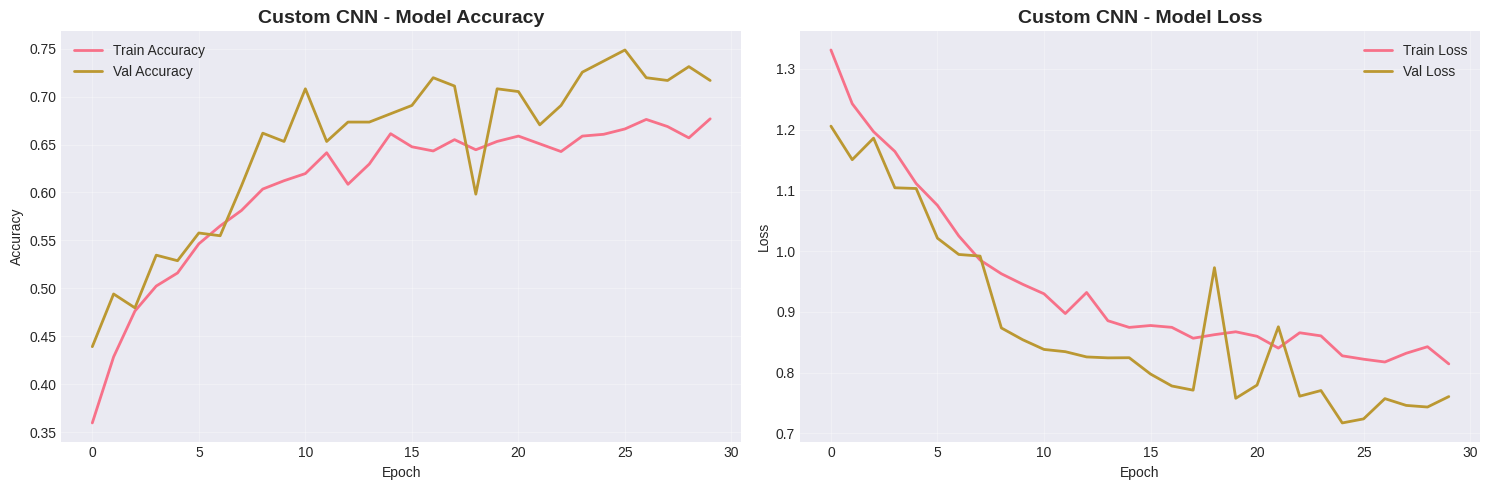


Custom CNN Best Scores:
   Best Validation Accuracy: 0.7486
   Best Validation Loss: 0.7171


In [43]:
# 9.2 Plot Custom CNN Training History
if history_custom is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history_custom.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history_custom.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('Custom CNN - Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot loss
    axes[1].plot(history_custom.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history_custom.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('Custom CNN - Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'custom_cnn_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print best scores
    best_val_acc = max(history_custom.history['val_accuracy'])
    best_val_loss = min(history_custom.history['val_loss'])
    print(f"\nCustom CNN Best Scores:")
    print(f"   Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"   Best Validation Loss: {best_val_loss:.4f}")

## 10. Model Training - Transfer Learning (MobileNetV2)
Train the transfer learning model with frozen base layers.

In [44]:
# 10.1 Train Transfer Learning Model
if transfer_model is not None and train_generator is not None:
    print("="*80)
    print("Training Transfer Learning Model (MobileNetV2)")
    print("="*80)
    
    start_time = time.time()
    
    history_transfer = transfer_model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=transfer_callbacks,
        #class_weight=class_weight_dict,  # Apply class weights for imbalance
        verbose=1
    )
    
    # Calculate training time
    training_time_transfer = time.time() - start_time
    
    print(f"\nTransfer Learning Model Training Complete!")
    print(f"Training Time: {training_time_transfer/60:.2f} minutes ({training_time_transfer:.2f} seconds)")
    print(f"Best model saved to: {MODELS_DIR / 'mobilenetv2_transfer_best.h5'}")
    
    # Save training time
    with open(RESULTS_DIR / 'mobilenetv2_training_time.txt', 'w') as f:
        f.write(f"Training Time: {training_time_transfer:.2f} seconds\n")
        f.write(f"Training Time: {training_time_transfer/60:.2f} minutes\n")
    
else:
    print("WARNING: Cannot train model. Please ensure dataset is loaded and model is created.")
    history_transfer = None
    training_time_transfer = 0

Training Transfer Learning Model (MobileNetV2)
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6516 - auc: 0.8500 - loss: 0.9612 - precision: 0.6981 - recall: 0.5878
Epoch 1: val_accuracy improved from -inf to 0.94220, saving model to ../models/mobilenetv2_transfer_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 893ms/step - accuracy: 0.6540 - auc: 0.8517 - loss: 0.9549 - precision: 0.7003 - recall: 0.5907 - val_accuracy: 0.9422 - val_auc: 0.9965 - val_loss: 0.1414 - val_precision: 0.9474 - val_recall: 0.9364
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8667 - auc: 0.9769 - loss: 0.3707 - precision: 0.8820 - recall: 0.8564
Epoch 2: val_accuracy improved from 0.94220 to 0.95087, saving model to ../models/mobilenetv2_transfer_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 586ms/step - accuracy: 0.8667 - auc: 0.9769 - loss: 0.3707 - precision: 0.8820 - recall: 0.8564 - val_accuracy: 0.9509 - val_auc: 0.9977 - val_loss: 0.1229 - val_precision: 0.9507 - val_recall: 0.9480
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8958 - auc: 0.9834 - loss: 0.2985 - precision: 0.9029 - recall: 0.8861
Epoch 3: val_accuracy did not improve from 0.95087
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 568ms/step - accuracy: 0.8957 - auc: 0.9834 - loss: 0.2988 - precision: 0.9028 - recall: 0.8860 - val_accuracy: 0.9480 - val_auc: 0.9956 - val_loss: 0.1357 - val_precision: 0.9480 - val_recall: 0.9480
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8992 - auc: 0.9858 - loss: 0.2708 - precision: 0.9053 - recall: 0.8846
Epoch 4: val_accuracy improved from 0.95087 to 0.95665, saving model to ../models/mobilenetv2_transfer_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - accuracy: 0.8993 - auc: 0.9858 - loss: 0.2706 - precision: 0.9054 - recall: 0.8848 - val_accuracy: 0.9566 - val_auc: 0.9967 - val_loss: 0.1020 - val_precision: 0.9593 - val_recall: 0.9538
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9020 - auc: 0.9844 - loss: 0.2691 - precision: 0.9102 - recall: 0.8933
Epoch 5: val_accuracy did not improve from 0.95665
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 583ms/step - accuracy: 0.9020 - auc: 0.9844 - loss: 0.2689 - precision: 0.9103 - recall: 0.8934 - val_accuracy: 0.9480 - val_auc: 0.9960 - val_loss: 0.1388 - val_precision: 0.9507 - val_recall: 0.9480
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8886 - auc: 0.9850 - loss: 0.2942 - precision: 0.8937 - recall: 0.8799
Epoch 6: val_accuracy did not improve from 0.95665
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 561ms/step - accuracy: 0.8890 - auc: 0.9851 - loss: 0.2934 - precision: 0.8942 - recall: 0.8803 - val_accuracy: 0.9538 - val_auc:

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 577ms/step - accuracy: 0.9212 - auc: 0.9915 - loss: 0.2108 - precision: 0.9326 - recall: 0.9168 - val_accuracy: 0.9595 - val_auc: 0.9948 - val_loss: 0.1304 - val_precision: 0.9595 - val_recall: 0.9595
Epoch 10/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9303 - auc: 0.9935 - loss: 0.1892 - precision: 0.9347 - recall: 0.9247
Epoch 10: val_accuracy improved from 0.95954 to 0.96243, saving model to ../models/mobilenetv2_transfer_best.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 594ms/step - accuracy: 0.9302 - auc: 0.9934 - loss: 0.1896 - precision: 0.9347 - recall: 0.9247 - val_accuracy: 0.9624 - val_auc: 0.9967 - val_loss: 0.1144 - val_precision: 0.9624 - val_recall: 0.9624
Epoch 11/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9356 - auc: 0.9930 - loss: 0.1897 - precision: 0.9430 - recall: 0.9280
Epoch 11: val_accuracy did not improve from 0.96243
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 566ms/step - accuracy: 0.9356 - auc: 0.9930 - loss: 0.1898 - precision: 0.9429 - recall: 0.9280 - val_accuracy: 0.9422 - val_auc: 0.9944 - val_loss: 0.1365 - val_precision: 0.9477 - val_recall: 0.9422
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 4.

Transfer Learning Model Training Complete!
Training Time: 5.89 minutes (353.44 seconds)
Best model saved to: ../models/mobilenetv2_transfer_best.h5


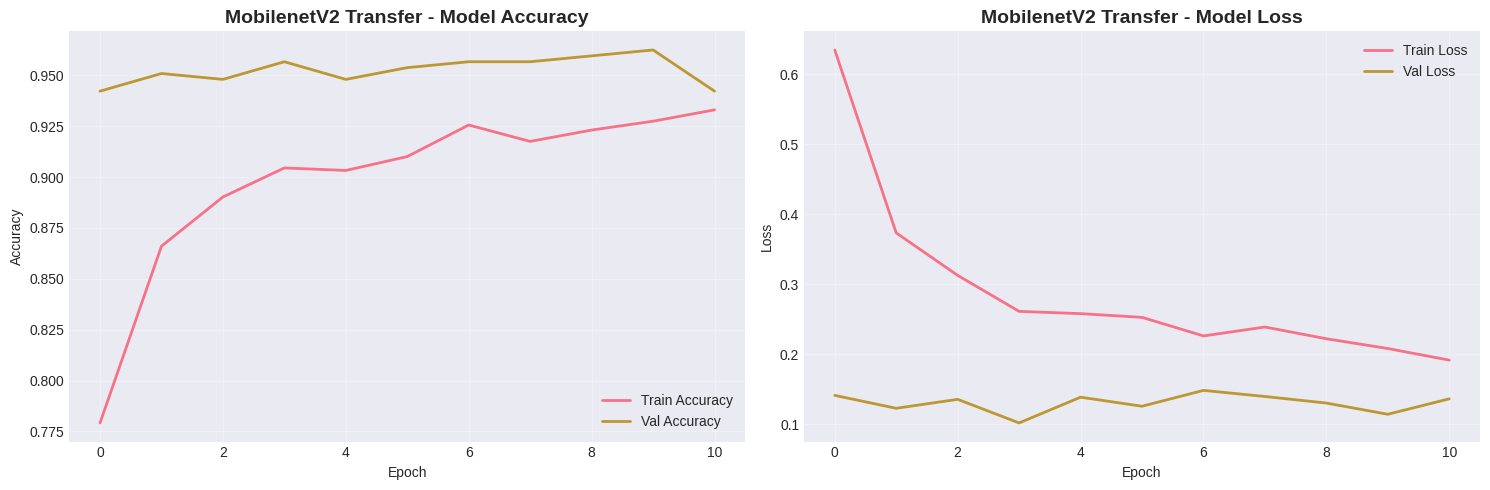


MobilenetV2 Best Scores:
   Best Validation Accuracy: 0.9624
   Best Validation Loss: 0.1020


In [45]:
# 10.2 Plot Transfer Learning Training History
if history_transfer is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history_transfer.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history_transfer.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('MobilenetV2 Transfer - Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot loss
    axes[1].plot(history_transfer.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history_transfer.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('MobilenetV2 Transfer - Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'mobilenetv2_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print best scores
    best_val_acc = max(history_transfer.history['val_accuracy'])
    best_val_loss = min(history_transfer.history['val_loss'])
    print(f"\nMobilenetV2 Best Scores:")
    print(f"   Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"   Best Validation Loss: {best_val_loss:.4f}")

## 11. Performance Evaluation and Metrics Calculation
**Rubric Requirement (13 marks)**: Comprehensive evaluation with accuracy, precision, recall, F1-score

Evaluate both models on the test set and compare performance.

In [46]:
# 11.1 Evaluate Custom CNN on Test Set
if custom_cnn is not None and test_generator is not None:
    print("="*80)
    print("Evaluating Custom CNN on Test Set")
    print("="*80)
    
    # Reset test generator
    test_generator.reset()
    
    # Get predictions
    y_pred_custom = custom_cnn.predict(test_generator, verbose=1)
    y_pred_classes_custom = np.argmax(y_pred_custom, axis=1)
    
    # Get true labels
    y_true = test_generator.classes[:len(y_pred_classes_custom)]
    
    # Calculate metrics
    accuracy_custom = accuracy_score(y_true, y_pred_classes_custom)
    precision_custom = precision_score(y_true, y_pred_classes_custom, average='weighted', zero_division=0)
    recall_custom = recall_score(y_true, y_pred_classes_custom, average='weighted', zero_division=0)
    f1_custom = f1_score(y_true, y_pred_classes_custom, average='weighted', zero_division=0)
    
    print(f"\nCustom CNN Test Results:")
    print("="*60)
    print(f"Accuracy:  {accuracy_custom:.4f} ({accuracy_custom*100:.2f}%)")
    print(f"Precision: {precision_custom:.4f}")
    print(f"Recall:    {recall_custom:.4f}")
    print(f"F1-Score:  {f1_custom:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print("="*60)
    report_custom = classification_report(y_true, y_pred_classes_custom, 
                                         target_names=class_names,
                                         digits=4)
    print(report_custom)
    
    # Save report
    with open(RESULTS_DIR / 'custom_cnn_classification_report.txt', 'w') as f:
        f.write("Custom CNN Classification Report\n")
        f.write("="*60 + "\n")
        f.write(f"Accuracy: {accuracy_custom:.4f}\n")
        f.write(f"Precision: {precision_custom:.4f}\n")
        f.write(f"Recall: {recall_custom:.4f}\n")
        f.write(f"F1-Score: {f1_custom:.4f}\n\n")
        f.write(report_custom)
    
else:
    print("WARNING: Cannot evaluate. Please ensure model is trained and test data is available.")
    y_pred_classes_custom = None
    accuracy_custom = 0
    precision_custom = 0
    recall_custom = 0
    f1_custom = 0

Evaluating Custom CNN on Test Set
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step

Custom CNN Test Results:
Accuracy:  0.6908 (69.08%)
Precision: 0.6919
Recall:    0.6908
F1-Score:  0.6640

Detailed Classification Report:
              precision    recall  f1-score   support

    Elephant     0.6667    0.2254    0.3368        71
   Orangutan     0.7838    0.7838    0.7838        74
    Panthers     0.7071    0.8235    0.7609        85
       Rhino     0.6376    0.8190    0.7170       116

    accuracy                         0.6908       346
   macro avg     0.6988    0.6629    0.6496       346
weighted avg     0.6919    0.6908    0.6640       346



In [47]:
# 11.2 Evaluate Transfer Learning Model on Test Set
if transfer_model is not None and test_generator is not None:
    print("="*80)
    print("Evaluating MobilenetV2 Transfer Learning on Test Set")
    print("="*80)
    
    # Reset test generator
    test_generator.reset()
    
    # Get predictions
    y_pred_transfer = transfer_model.predict(test_generator, verbose=1)
    y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
    
    # Get true labels
    y_true = test_generator.classes[:len(y_pred_classes_transfer)]
    
    # Calculate metrics
    accuracy_transfer = accuracy_score(y_true, y_pred_classes_transfer)
    precision_transfer = precision_score(y_true, y_pred_classes_transfer, average='weighted', zero_division=0)
    recall_transfer = recall_score(y_true, y_pred_classes_transfer, average='weighted', zero_division=0)
    f1_transfer = f1_score(y_true, y_pred_classes_transfer, average='weighted', zero_division=0)
    
    print(f"\nMobilenetV2 Transfer Test Results:")
    print("="*60)
    print(f"Accuracy:  {accuracy_transfer:.4f} ({accuracy_transfer*100:.2f}%)")
    print(f"Precision: {precision_transfer:.4f}")
    print(f"Recall:    {recall_transfer:.4f}")
    print(f"F1-Score:  {f1_transfer:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print("="*60)
    report_transfer = classification_report(y_true, y_pred_classes_transfer, 
                                           target_names=class_names,
                                           digits=4)
    print(report_transfer)
    
    # Save report
    with open(RESULTS_DIR / 'mobilenetv2_classification_report.txt', 'w') as f:
        f.write(" MobilenetV2 Transfer Learning Classification Report\n")
        f.write("="*60 + "\n")
        f.write(f"Accuracy: {accuracy_transfer:.4f}\n")
        f.write(f"Precision: {precision_transfer:.4f}\n")
        f.write(f"Recall: {recall_transfer:.4f}\n")
        f.write(f"F1-Score: {f1_transfer:.4f}\n\n")
        f.write(report_transfer)
    
else:
    print("WARNING: Cannot evaluate. Please ensure model is trained and test data is available.")
    y_pred_classes_transfer = None
    accuracy_transfer = 0
    precision_transfer = 0
    recall_transfer = 0
    f1_transfer = 0

Evaluating MobilenetV2 Transfer Learning on Test Set
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 638ms/step

MobilenetV2 Transfer Test Results:
Accuracy:  0.9798 (97.98%)
Precision: 0.9801
Recall:    0.9798
F1-Score:  0.9798

Detailed Classification Report:
              precision    recall  f1-score   support

    Elephant     1.0000    0.9718    0.9857        71
   Orangutan     1.0000    0.9865    0.9932        74
    Panthers     0.9540    0.9765    0.9651        85
       Rhino     0.9744    0.9828    0.9785       116

    accuracy                         0.9798       346
   macro avg     0.9821    0.9794    0.9806       346
weighted avg     0.9801    0.9798    0.9798       346



## 12. Confusion Matrix Visualization
**Rubric Requirement (13 marks)**: Generate confusion matrices for both models

Confusion matrices help identify which classes are being confused by the models.

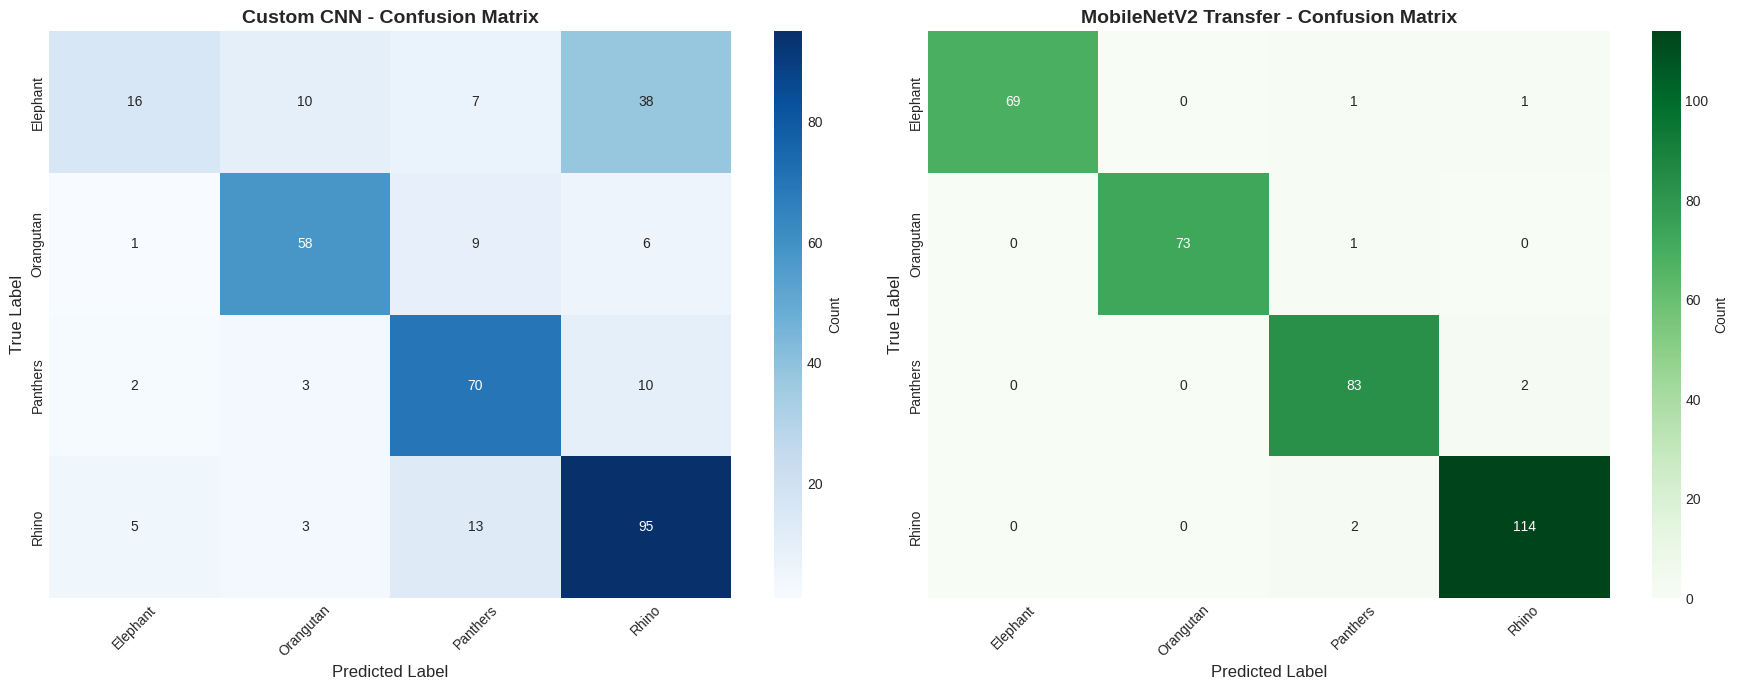

Confusion matrices generated and saved

Interpretation:
   - Diagonal elements: Correct predictions
   - Off-diagonal elements: Misclassifications
   - Darker colors indicate higher counts


In [48]:
# 12.1 Generate and Visualize Confusion Matrices
if y_pred_classes_custom is not None and y_pred_classes_transfer is not None:
    # Create confusion matrices
    cm_custom = confusion_matrix(y_true, y_pred_classes_custom)
    cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
    
    # Plot side-by-side confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Custom CNN Confusion Matrix
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Custom CNN - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Transfer Learning Confusion Matrix
    sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title('MobileNetV2 Transfer - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Confusion matrices generated and saved")
    print("\nInterpretation:")
    print("   - Diagonal elements: Correct predictions")
    print("   - Off-diagonal elements: Misclassifications")
    print("   - Darker colors indicate higher counts")
    
else:
    print("WARNING: Cannot generate confusion matrices. Please ensure models are evaluated.")

## 13. Model Comparison Analysis
**Rubric Requirement (13 marks)**: Compare performance, training time, and model complexity

Create comprehensive comparison of both models across all metrics.

COMPREHENSIVE MODEL COMPARISON


Metric Custom CNN  MobileNetV2 Transfer
0             Accuracy     0.6908                0.9798
1            Precision     0.6919                0.9801
2               Recall     0.6908                0.9798
3             F1-Score     0.6640                0.9798
4  Training Time (min)      15.25                  5.89
5           Parameters     93,764             3,053,380
6      Model Size (MB)       0.36                 11.65

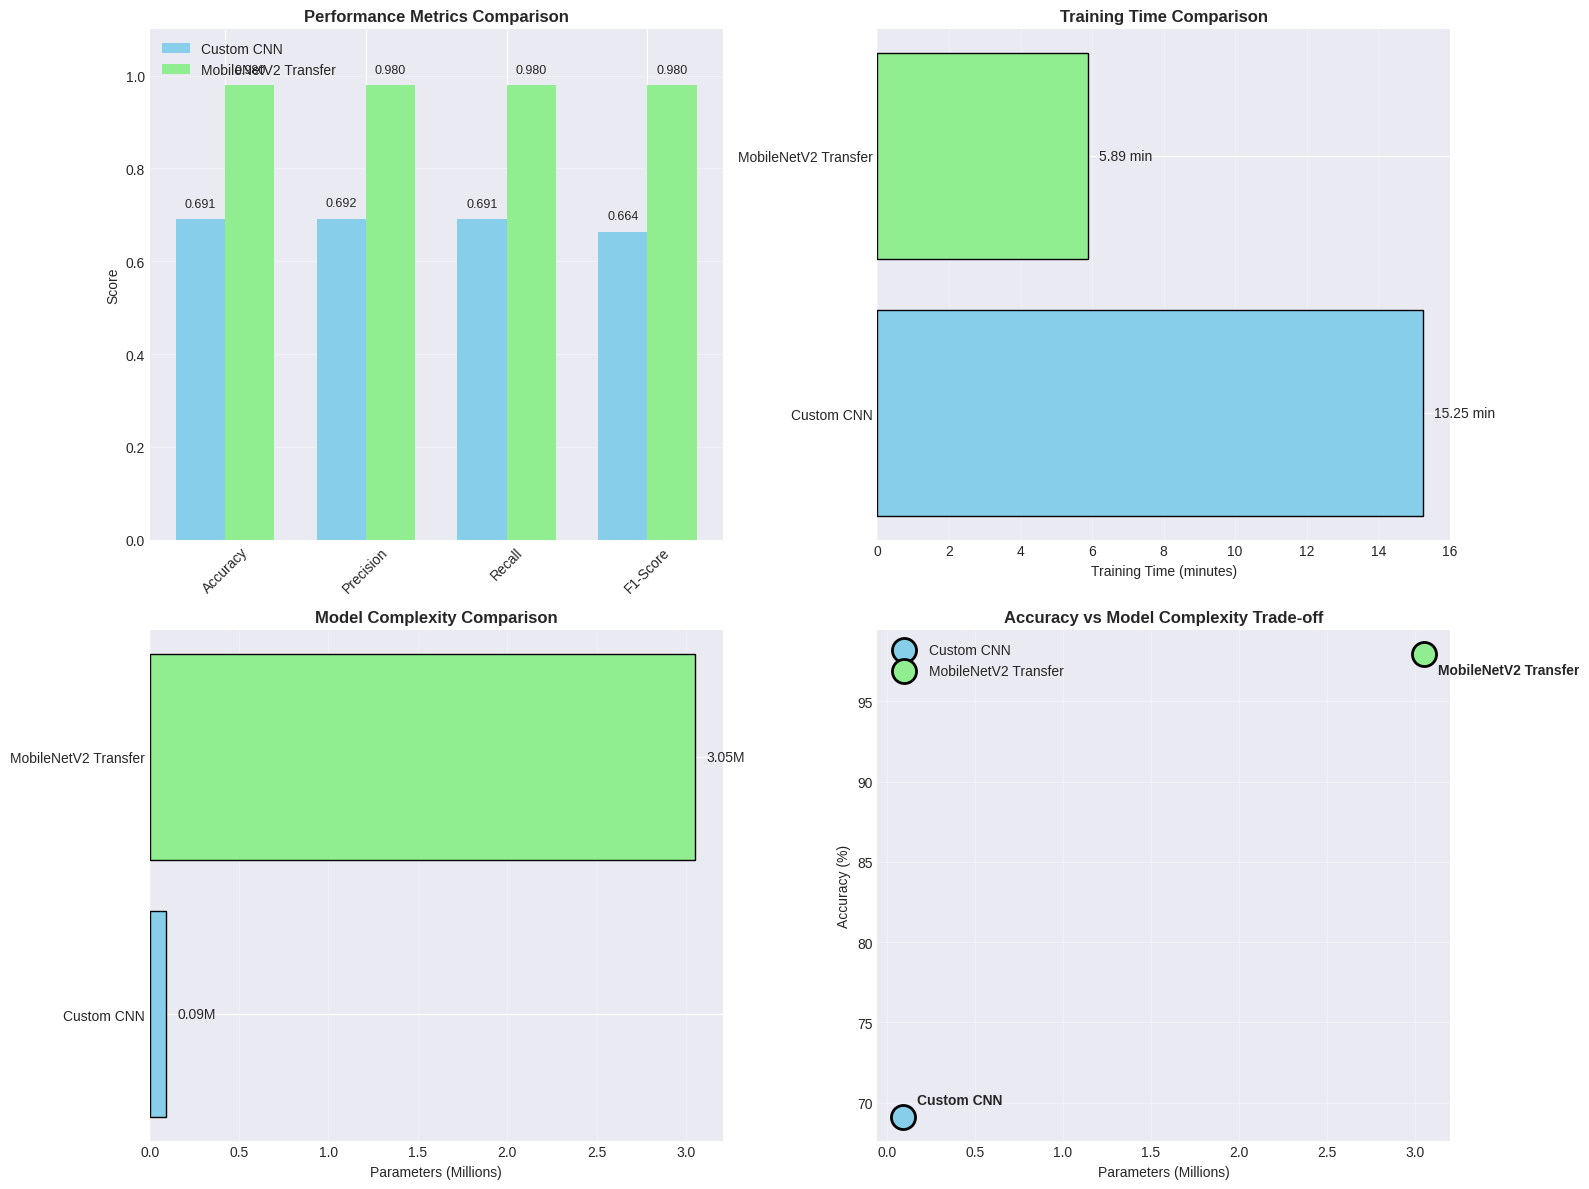


ANALYSIS SUMMARY
Winner (Accuracy): MobileNetV2 Transfer Learning by 28.90%

Training Time: Custom CNN is 0.39x faster
Model Size: Custom CNN is 32.56x smaller

Trade-offs:
   - Custom CNN: Faster training, smaller size, good baseline performance
   - MobileNetV2 Transfer: Better accuracy, leverages pre-trained features, larger model


In [49]:
# 13.1 Create Comprehensive Model Comparison
if custom_cnn is not None and transfer_model is not None:
    # Create comparison dataframe
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 
                   'Training Time (min)', 'Parameters', 'Model Size (MB)'],
        'Custom CNN': [
            f"{accuracy_custom:.4f}",
            f"{precision_custom:.4f}",
            f"{recall_custom:.4f}",
            f"{f1_custom:.4f}",
            f"{training_time_custom/60:.2f}",
            f"{custom_cnn.count_params():,}",
            f"{custom_cnn.count_params() * 4 / (1024**2):.2f}"
        ],
        ' MobileNetV2 Transfer': [
            f"{accuracy_transfer:.4f}",
            f"{precision_transfer:.4f}",
            f"{recall_transfer:.4f}",
            f"{f1_transfer:.4f}",
            f"{training_time_transfer/60:.2f}",
            f"{transfer_model.count_params():,}",
            f"{transfer_model.count_params() * 4 / (1024**2):.2f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("="*80)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*80)
    display(comparison_df)
    
    # Save comparison
    comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
    
    # Create visual comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Metrics Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    custom_scores = [accuracy_custom, precision_custom, recall_custom, f1_custom]
    transfer_scores = [accuracy_transfer, precision_transfer, recall_transfer, f1_transfer]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, custom_scores, width, label='Custom CNN', color='skyblue')
    axes[0, 0].bar(x + width/2, transfer_scores, width, label='MobileNetV2 Transfer', color='lightgreen')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Performance Metrics Comparison', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1.1])
    
    # Add value labels on bars
    for i, (v1, v2) in enumerate(zip(custom_scores, transfer_scores)):
        axes[0, 0].text(i - width/2, v1 + 0.02, f'{v1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0, 0].text(i + width/2, v2 + 0.02, f'{v2:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Training Time Comparison
    times = [training_time_custom/60, training_time_transfer/60]
    models = ['Custom CNN', 'MobileNetV2 Transfer']
    colors_time = ['skyblue', 'lightgreen']
    
    axes[0, 1].barh(models, times, color=colors_time, edgecolor='black')
    axes[0, 1].set_xlabel('Training Time (minutes)')
    axes[0, 1].set_title('Training Time Comparison', fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(times):
        axes[0, 1].text(v + max(times)*0.02, i, f'{v:.2f} min', va='center', fontsize=10)
    
    # 3. Model Complexity (Parameters)
    params = [custom_cnn.count_params()/1e6, transfer_model.count_params()/1e6]
    
    axes[1, 0].barh(models, params, color=colors_time, edgecolor='black')
    axes[1, 0].set_xlabel('Parameters (Millions)')
    axes[1, 0].set_title('Model Complexity Comparison', fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(params):
        axes[1, 0].text(v + max(params)*0.02, i, f'{v:.2f}M', va='center', fontsize=10)
    
    # 4. Accuracy vs Parameters Trade-off
    axes[1, 1].scatter([custom_cnn.count_params()/1e6], [accuracy_custom*100], 
                      s=300, color='skyblue', edgecolor='black', linewidth=2, 
                      label='Custom CNN', zorder=3)
    axes[1, 1].scatter([transfer_model.count_params()/1e6], [accuracy_transfer*100], 
                      s=300, color='lightgreen', edgecolor='black', linewidth=2,
                      label='MobileNetV2 Transfer', zorder=3)
    axes[1, 1].set_xlabel('Parameters (Millions)')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Accuracy vs Model Complexity Trade-off', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Add annotations
    axes[1, 1].annotate('Custom CNN', 
                       xy=(custom_cnn.count_params()/1e6, accuracy_custom*100),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=10, fontweight='bold')
    axes[1, 1].annotate('MobileNetV2 Transfer', 
                       xy=(transfer_model.count_params()/1e6, accuracy_transfer*100),
                       xytext=(10, -15), textcoords='offset points',
                       fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'model_comparison_charts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary Analysis
    print("\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)
    
    if accuracy_transfer > accuracy_custom:
        winner = "MobileNetV2 Transfer Learning"
        margin = (accuracy_transfer - accuracy_custom) * 100
        print(f"Winner (Accuracy): {winner} by {margin:.2f}%")
    else:
        winner = "Custom CNN"
        margin = (accuracy_custom - accuracy_transfer) * 100
        print(f"Winner (Accuracy): {winner} by {margin:.2f}%")
    
    time_ratio = training_time_transfer / training_time_custom
    print(f"\nTraining Time: Custom CNN is {time_ratio:.2f}x faster")
    
    param_ratio = transfer_model.count_params() / custom_cnn.count_params()
    print(f"Model Size: Custom CNN is {param_ratio:.2f}x smaller")
    
    print("\nTrade-offs:")
    print("   - Custom CNN: Faster training, smaller size, good baseline performance")
    print("   - MobileNetV2 Transfer: Better accuracy, leverages pre-trained features, larger model")
    
else:
    print("WARNING: Cannot create comparison. Please ensure both models are trained and evaluated.")

## 14. Interactive Prediction Demo
**Rubric Requirement**: Interactive demo for single image prediction

This section provides a function to predict wildlife class from any image with visual display of results.

In [50]:
# 14.1 Interactive Prediction Function
def predict_wildlife_image(image_path, model, class_names, model_name="Model"):
    """
    Predict wildlife class from an image and display results
    
    Args:
        image_path: Path to image file
        model: Trained Keras model
        class_names: List of class names
        model_name: Name of model for display
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Display image
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f'Input Image\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%',
                     fontsize=12, fontweight='bold', color='green' if confidence > 80 else 'orange')
    
    # Display prediction probabilities
    sorted_indices = np.argsort(predictions[0])[::-1]
    top_classes = [class_names[i] for i in sorted_indices]
    top_probs = [predictions[0][i] * 100 for i in sorted_indices]
    
    colors = ['green' if i == predicted_class_idx else 'lightblue' for i in sorted_indices]
    axes[1].barh(top_classes, top_probs, color=colors, edgecolor='black')
    axes[1].set_xlabel('Confidence (%)', fontsize=11)
    axes[1].set_title(f'{model_name} Prediction Probabilities', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 100])
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    for i, v in enumerate(top_probs):
        axes[1].text(v + 1, i, f'{v:.2f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("="*60)
    print(f"{model_name} Prediction Results")
    print("="*60)
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"\nTop 3 Predictions:")
    for i in range(min(3, len(class_names))):
        print(f"  {i+1}. {top_classes[i]}: {top_probs[i]:.2f}%")
    print("="*60)
    
    return predicted_class, confidence

print("Prediction function defined successfully")
print("   Use: predict_wildlife_image(image_path, model, class_names, model_name)")

Prediction function defined successfully
   Use: predict_wildlife_image(image_path, model, class_names, model_name)


Testing prediction function with random sample images...


Test Image 1: 265.jpg



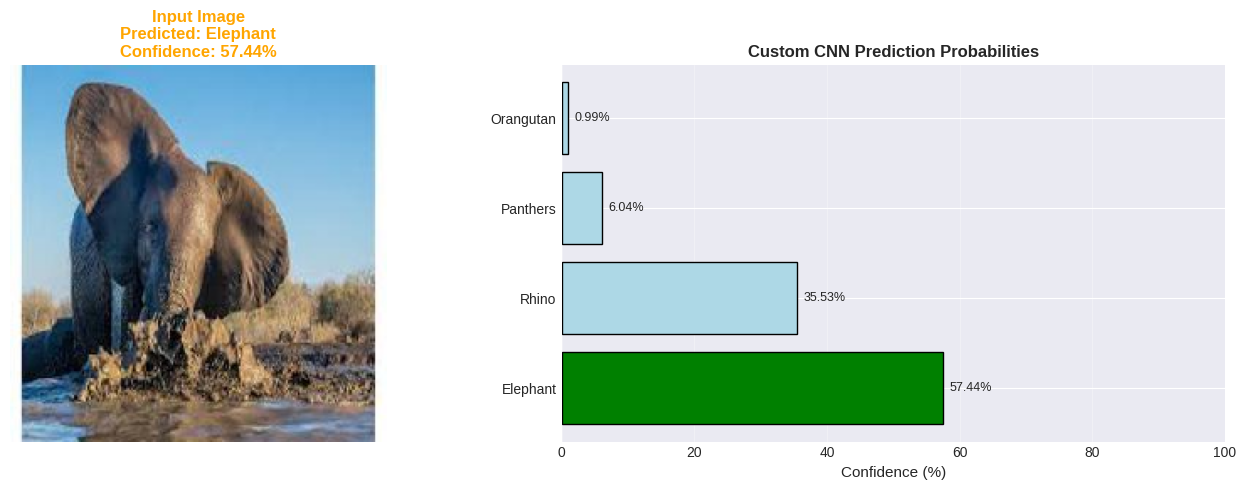

Custom CNN Prediction Results
Predicted Class: Elephant
Confidence: 57.44%

Top 3 Predictions:
  1. Elephant: 57.44%
  2. Rhino: 35.53%
  3. Panthers: 6.04%



Test Image 2: 116.jpg



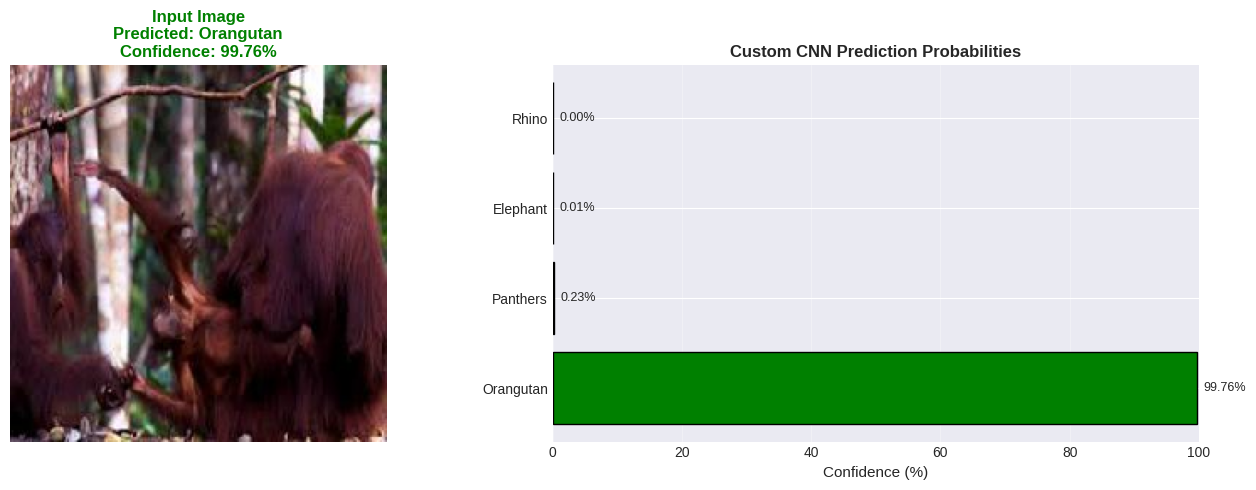

Custom CNN Prediction Results
Predicted Class: Orangutan
Confidence: 99.76%

Top 3 Predictions:
  1. Orangutan: 99.76%
  2. Panthers: 0.23%
  3. Elephant: 0.01%



To test with MobileNetV2 Transfer Learning model, use:
   predict_wildlife_image(image_path, transfer_model, class_names, 'MobileNetV2 Transfer')


In [51]:
# 14.2 Test Prediction Function with Sample Images
if len(dataset_df) > 0 and custom_cnn is not None:
    print("Testing prediction function with random sample images...\n")
    
    # Get random sample images from dataset (one from each class if possible)
    sample_images = []
    for class_name in class_names[:min(2, len(class_names))]:  # Test with 2 classes
        class_df = dataset_df[dataset_df['class'] == class_name]
        if len(class_df) > 0:
            sample = class_df.sample(1, random_state=SEED).iloc[0]
            sample_images.append(sample['filepath'])
    
    # Test with Custom CNN
    for i, img_path in enumerate(sample_images):
        print(f"\n{'='*80}")
        print(f"Test Image {i+1}: {Path(img_path).name}")
        print(f"{'='*80}\n")
        predict_wildlife_image(img_path, custom_cnn, class_names, "Custom CNN")
        print("\n")
    
    # Instructions for using with Transfer Learning model
    print("\n" + "="*80)
    print("To test with MobileNetV2 Transfer Learning model, use:")
    print("   predict_wildlife_image(image_path, transfer_model, class_names, 'MobileNetV2 Transfer')")
    print("="*80)
    
else:
    print("WARNING: Cannot run prediction demo. Please ensure dataset is loaded and models are trained.")
    print("\nTo use the prediction function:")
    print("   1. Ensure you have trained at least one model")
    print("   2. Call: predict_wildlife_image(image_path, model, class_names, model_name)")
    print("   3. Example: predict_wildlife_image('path/to/image.jpg', custom_cnn, class_names, 'Custom CNN')")

## 15. Save Models
Save trained models

In [53]:
# 15.1 Save Trained Models
if custom_cnn is not None and transfer_model is not None:
    print("="*80)
    print("Saving Trained Models")
    print("="*80)
    
    # Save models in native Keras format
    custom_cnn.save(MODELS_DIR / 'custom_cnn_final.keras')
    transfer_model.save(MODELS_DIR / 'mobilenetv2_transfer_final.keras')
    
    print(f"✅ Models saved successfully to {MODELS_DIR}/")
    print(f"   - custom_cnn_final.keras")
    print(f"   - mobilenetv2_transfer_final.keras")
    
    # Also check if best models exist from ModelCheckpoint
    if (MODELS_DIR / 'custom_cnn_best.h5').exists():
        print(f"\n📌 Best models from training also available:")
        print(f"   - custom_cnn_best.h5")
    if (MODELS_DIR / 'mobilenetv2_transfer_best.h5').exists():
        print(f"   - mobilenetv2_transfer_best.h5")
    
else:
    print("⚠️ WARNING: Models not found in memory!")
    print("   Did you train both models? The variables 'custom_cnn' and 'transfer_model' must exist.")
    print(f"   custom_cnn exists: {'custom_cnn' in dir()}")
    print(f"   transfer_model exists: {'transfer_model' in dir()}")

Saving Trained Models
✅ Models saved successfully to ../models/
   - custom_cnn_final.keras
   - mobilenetv2_transfer_final.keras

📌 Best models from training also available:
   - custom_cnn_best.h5
   - mobilenetv2_transfer_best.h5


In [54]:
# Check actual paths
print("MODELS_DIR path:", MODELS_DIR)
print("MODELS_DIR absolute:", MODELS_DIR.resolve())
print("MODELS_DIR exists:", MODELS_DIR.exists())
print("\nExpected location: c:\\Github\\CV\\Image-Classification-Wildlife\\models")

# List what's in the parent directory
print("\nContents of parent directory:")
for item in Path('..').iterdir():
    print(f"  {item.name}{'/' if item.is_dir() else ''}")

# Try to find the .keras files anywhere
print("\nSearching for .keras files...")
import os
for root, dirs, files in os.walk('..'):
    for file in files:
        if file.endswith('.keras') or file.endswith('.h5'):
            print(f"  Found: {os.path.join(root, file)}")

MODELS_DIR path: ../models
MODELS_DIR absolute: /models
MODELS_DIR exists: True

Expected location: c:\Github\CV\Image-Classification-Wildlife\models

Contents of parent directory:
  proc/
  etc/
  run/
  home/
  lib64/
  lib/
  mnt/
  lib32/
  usr/
  var/
  media/
  sys/
  bin/
  opt/
  libx32/
  srv/
  tmp/
  dev/
  sbin/
  root/
  boot/
  results/
  models/
  kaggle/
  .dockerenv
  tools/
  datalab/
  content/
  python-apt/
  python-apt.tar.xz
  NGC-DL-CONTAINER-LICENSE
  cuda-keyring_1.1-1_all.deb

Searching for .keras files...
  Found: ../usr/local/lib/python3.12/dist-packages/tables/tests/smpl_unsupptype.h5
  Found: ../usr/local/lib/python3.12/dist-packages/tables/tests/flavored_vlarrays-format1.6.h5
  Found: ../usr/local/lib/python3.12/dist-packages/tables/tests/smpl_f64be.h5
  Found: ../usr/local/lib/python3.12/dist-packages/tables/tests/smpl_SDSextendible.h5
  Found: ../usr/local/lib/python3.12/dist-packages/tables/tests/Table2_1_lzo_nrv2e_shuffle.h5
  Found: ../usr/local/lib/